## Data Mining - MSDS 7331 - Thurs 6:30, Summer 2016
Team 3: Sal Melendez, Rahn Lieberman, Thomas Rogers

Github page: https://github.com/RahnL/DataScience-SMU/tree/master/DataMining

### Overview

Our team chose to pursue collaborative filtering to build a custom recommendation system (Option C), using Amazon Instant Video recommendation data (http://jmcauley.ucsd.edu/data/amazon/).

#### Business Understanding

In the world of digital commerce, engagement equates to revenue and personalization ensures “stickiness”. Amazon understood these concepts before most and leveraged data science to enable mass personalization on a scale not previously possible through their recommender system. The distinction between mass marketing and personalized marketing is best measured by effectiveness. Mass marketing feels intrusive and often consists of tactics that are “pushed” to potential consumers. The flipside of the push is a “pull” which is a similarly motivated message, but through personalization almost feels helpful.

An effective and scalable recommendation system is a competitive differentiator in many different markets. Consider that at its core, Amazon is a fairly simple marketplace with buyers and sellers. What makes Amazon powerful, beyond the breadth of offerings available, is that it brings insight to both sides of the buying and selling equation, with its recommendation system. 

Understanding the importance of recommender systems in digital commerce requires a bit of context. It may be that an algorithm exists to perfectly recommend a product to a person at the right place at the right time, but without elements like an effective user interface or without consideration for the user experience, that recommendation never makes it to the site visitor. 

#### Data Understanding

The data for this effort is taken from product reviews and metadata from Amazon, including 142.8 million reviews spanning from May of 1996 to July of 2014. Our analysis focuses specifically on Amazon Instant Video reviews and contains the following variables of the following types:
- asin – this is a unique variable defined by Amazon as, “A 10-character alphanumeric unique identifier assigned by Amazon.com and its partners for product identification within the Amazon organization.”
- helpful – this is a 1 x 2 matrix of numeric values, indicating whether the review was found helpful by a person viewing it. (thoughts here?)
- overall – this numeric value scales from 0 to 5 in whole increments.
- reviewText – this alpha-numeric value consists of free-form text from users writing whatever they think may be helpful as a narrative review.
- reviewTime – this variable consists of MM DD, YYYY and represents the date the review was made
- reviewerID – this unique identifier is a 14-character alpha-numeric used to identify the person providing the review
- reviewerName – this alphanumeric variable is user-defined and is the name that appears as the reviewer in the web application
- summary – this alphanumeric text represents a sample of the reviewText variable
- unixReviewTime – this ten-digit variable represents the time a review was given, in a standard format

#### Import the data

Below we set everything up by importing the data and looking at the first few records to validate what we expect to see in it.
Instead of pulling the dataset from the web, we have a local copy of it.

In [21]:
import graphlab as gl
import pandas
# set canvas to show sframes and sgraphs in ipython notebook
gl.canvas.set_target('ipynb')
import matplotlib.pyplot as plt
%matplotlib inline


# some Global settings
# so we are standard across any recommenders that we build.

# specify how many users to look up, so we don't need to look up everyone.
# This is the number k, in the documentation.
number_users = 5

# specify how many reviews to consider.
number_reviews = 10

In [22]:
# Load the data.  It's already been downloaded from the site listed above
# amazonfile = 'C:/Users/trogers/Documents/GitHub/DataScience-SMU/DataMining/data/Amazon_Instant_Video_5.json'
amazonfile = './data/Amazon_Instant_Video_5.json'
sf = gl.SFrame.read_json(amazonfile,orient='lines')
sf.head()

Finished parsing file C:\Users\rahnl\OneDrive\Documents\GitHub\DataScience-SMU\DataMining\data\Amazon_Instant_Video_5.json

Parsing completed. Parsed 100 lines in 1.12961 secs.

------------------------------------------------------
Inferred types from first 100 line(s) of file as 
column_type_hints=[dict]
If parsing fails due to incorrect types, you can correct
the inferred type list above and pass it to read_csv in
the column_type_hints argument
------------------------------------------------------


Finished parsing file C:\Users\rahnl\OneDrive\Documents\GitHub\DataScience-SMU\DataMining\data\Amazon_Instant_Video_5.json

Parsing completed. Parsed 37126 lines in 0.500282 secs.

asin,helpful,overall,reviewText,reviewTime,reviewerID
B000H00VBQ,"[0, 0]",2.0,I had big expectationsbecause I love English ...,"05 3, 2014",A11N155CW1UV02
B000H00VBQ,"[0, 0]",5.0,I highly recommend thisseries. It is a must for ...,"09 3, 2012",A3BC8O2KCL29V2
B000H00VBQ,"[0, 1]",1.0,This one is a realsnoozer. Don't believe ...,"10 16, 2013",A60D5HQFOTSOM
B000H00VBQ,"[0, 0]",4.0,Mysteries areinteresting. The ten ...,"10 30, 2013",A1RJPIGRSNX4PW
B000H00VBQ,"[1, 1]",5.0,"This show always isexcellent, as far as ...","02 11, 2009",A16XRPF40679KG
B000H00VBQ,"[12, 12]",5.0,I discovered this seriesquite by accident. Ha ...,"10 11, 2011",A1POFVVXUZR3IQ
B000H0X79O,"[0, 0]",3.0,"It beats watching a blankscreen. However, I just ...","10 15, 2013",A1PG2VV4W1WRPL
B000H0X79O,"[0, 0]",3.0,"There are many episodesin this series, so I ...","12 29, 2013",ATASGS8HZHGIB
B000H0X79O,"[0, 0]",5.0,This is the best of thebest comedy Stand-up. ...,"02 26, 2014",A3RXD7Z44T9DHW
B000H0X79O,"[0, 0]",3.0,Not bad. Didn't know anyof the comedians but ...,"04 2, 2014",AUX8EUBNTHIIU


---

The table above is showing the fields in the dataset.  The three primary variables we are interested in is the ASIN, rating, and reviewer.

The reviewer is the person who just watched a particular video, identified by the ASIN.  Based on the video, we want to recommend other videos (ASIN's) based on what other people have watchined who have also seen the just-viewed data, and have rated the other videos high.

#### Data Quality

The basic descriptive statistics below demonstrate that there are no missing values, duplicate data or outliers. The data is clean and nothing needs fixing. Interesting to note that the average overall rating is a 4.2, that seems high and raises a question, do people only rate movies if they enjoy them?

In [23]:
sf['overall'].mean()

4.209529709637443

In [24]:
sf['overall'].std()

1.1185346025400438

### Data Visualization

This section does some visualization of the initital data, in order to explore it a bit, and see what we're working with from a different perspective.


In [25]:
# Reading the JSON file into pandas for analysis and visualization

import matplotlib.pyplot as plt
import pandas as pd
pd.options.display.mpl_style = 'default'
with open(amazonfile, 'rb') as f:
    data = f.readlines()

# remove the trailing "\n" from each line
data = map(lambda x: x.rstrip(), data)

# each element of 'data' is an individual JSON object.
# i want to convert it into an *array* of JSON objects
# which, in and of itself, is one large JSON object
# basically... add square brackets to the beginning
# and end, and have all the individual business JSON objects
# separated by a comma
data_json_str = "[" + ','.join(data) + "]"

# now, load it into pandas
data_df = pd.read_json(data_json_str)

---

The graph below shows a histogram of the review ratings.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000000016294E48>]], dtype=object)

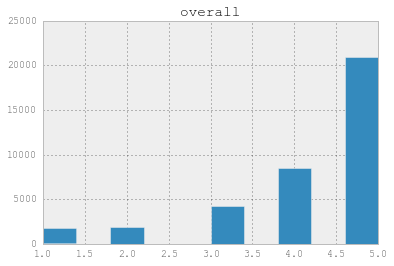

In [26]:
pd.options.display.mpl_style = 'default'
data_df.hist('overall')

The majority of them are rating a 5.0, which is a little puzzling.  


In [27]:
asingrouped = data_df.groupby('asin').mean()
asingrouped.sort_values(by='overall',ascending=False)

,overall,unixReviewTime
asin,,
B00A1ZV2KG,5.000000,1.393114e+09
B00D6MQ6ZM,5.000000,1.390522e+09
B00DI2NTK0,5.000000,1.379318e+09
B00332YHLU,5.000000,1.388252e+09
B004SKQHYQ,5.000000,1.356964e+09
B009DNVLH6,5.000000,1.387567e+09
B003336P1Y,5.000000,1.378401e+09
B00B09HOGI,5.000000,1.381647e+09
B009KZYJ62,5.000000,1.385320e+09


##### Build the model

We randomly split our data into a training (80%) and test (20%) sets.

In [28]:
(train_set, test_set) = sf.random_split(0.8, seed=1)

First, we'll create a popularity model, which is based just off the ratings field in the file.

In [29]:
# remember "overall" is the rating field.

popularity_model = gl.popularity_recommender.create(train_set, user_id='reviewerID', item_id='asin',
                                                    target='overall', 
                                                    user_data=None, 
                                                    item_data=None,
                                                    random_seed=0,
                                                    verbose=True)

Recsys training: model = popularity

Warning: Ignoring columns helpful, reviewText, reviewTime, reviewerName, summary, unixReviewTime;

To use these columns in scoring predictions, use a model that allows the use of additional features.

Preparing data set.

Data has 29707 observations with 5130 users and 1685 items.

Data prepared in: 0.052138s

29707 observations to process; with 1685 unique items.

---
Using the popularity model, lets looks at the first few recommendations, and evaluate for ourselves if they look good. 

The popularity model is a good baseline recommender to use to compare against other recommenders, to see how they do against each other. This creates recommendations based on how often something is seen in the training set, and is good for sparse data or where a specific user may not be specified.


*** Note that you can look up ASIN's on Amazon using a special URL format, or typing it into the search button.  For this sample, we didn't create an account that would allow us to auto-look these up in code.  The look up is done by hand. *

In [31]:
popularity_model.recommend(users=range(1,number_users),k=number_reviews)

reviewerID,asin,score,rank
1,B003336P1Y,5.0,1
1,B00332YHLU,5.0,2
1,B002T33I64,5.0,3
1,B001NJO76U,5.0,4
1,B001I8O2MK,5.0,5
1,B001ATJQB4,5.0,6
1,B000VU2STU,5.0,7
1,B000ULZLYY,5.0,8
1,B000UERE3M,5.0,9
1,B000IKP5AM,5.0,10


---

1. https://www.amazon.com/exec/obidos/ASIN/B003336P1Y : Curious George (Season 3)
2. https://www.amazon.com/exec/obidos/ASIN/B00332YHLU : Curious George (Season 2)
3. https://www.amazon.com/exec/obidos/ASIN/B002T33I64 : Sesame Street (Season 36)
4. https://www.amazon.com/exec/obidos/ASIN/B001NJO76U : Dirty Jobs (Season 1)
5. https://www.amazon.com/exec/obidos/ASIN/B001I8O2MK : ER (Season 15)

For the first 3, these seem reasonable.  A kid watching a show would want to watch more of the same, or a another kids show.


---
##### Collaborative filtering

Next, lets create a collaborative filter.  This will make predictions based on other users activities, such as people who watch Curious George also watch Sesame Street.

For similarity type, we can chose between three type:
* **Jaccard:**  This is typically used in boolean decisions, not ratings.
* **Cosine:** 
* **Pearson:**



In [35]:
item_sim_model = gl.item_similarity_recommender.create(train_set, 
                                                       user_id='reviewerID', 
                                                       item_id='asin',
                                                       target='overall',
                                                       similarity_type='pearson'
                                                      )



Recsys training: model = item_similarity

Warning: Ignoring columns helpful, reviewText, reviewTime, reviewerName, summary, unixReviewTime;

To use these columns in scoring predictions, use a model that allows the use of additional features.

Preparing data set.

Data has 29707 observations with 5130 users and 1685 items.

Data prepared in: 0.054699s

Training model from provided data.

Gathering per-item and per-user statistics.

+--------------------------------+------------+

| Elapsed Time (Item Statistics) | % Complete |

+--------------------------------+------------+

| 2.009ms                        | 58.25      |

| 3.014ms                        | 100        |

+--------------------------------+------------+

Setting up lookup tables.

Processing data in one pass using dense lookup tables.

+-------------------------------------+------------------+-----------------+

| Elapsed Time (Constructing Lookups) | Total % Complete | Items Processed |

+-------------------------------------+------------------+-----------------+

| 199.157ms                           | 0                | 1               |

| 251.799ms                           | 100              | 1685            |

+-------------------------------------+------------------+-----------------+

Finalizing lookup tables.

Generating candidate set for working with new users.

Finished training in 0.295918s

--- 
And again, a simple sanity check:


In [34]:
item_sim_model.recommend(users=range(1,number_users),k=number_reviews)


reviewerID,asin,score,rank
1,B00I3MNGCG,0.0350060808659,1
1,B00CDBR1P6,0.0338644742966,2
1,B00I3MPDP4,0.033683552742,3
1,B00I3MNVBW,0.0330168366432,4
1,B00I3MMTS8,0.031788932085,5
1,B00CDBTQCW,0.0315881764889,6
1,B00CBNOD0W,0.0305130386353,7
1,B00CBNOBYU,0.0296063923836,8
1,B00APE00H4,0.0280364501476,9
1,B00CDBQNZU,0.0270222604275,10


---
1. https://www.amazon.com/exec/obidos/ASIN/B00I3MPDP4 : Bosch (Season 1)
2. https://www.amazon.com/exec/obidos/ASIN/B00I3MNGCG : Mozart in the Jungle (Season 1)
3. https://www.amazon.com/exec/obidos/ASIN/B00I3MMTS8 : Transparent (Season 1)
4. https://www.amazon.com/exec/obidos/ASIN/B00I3MNVBW : The Rebels (Season 1)
5. https://www.amazon.com/exec/obidos/ASIN/B00C6C96UK : Kill Zombies

While this is a bit of a random assortment, it seems like a reasonable set of things to recommend.  The first 4 are drama's, and the comedy movie.


Next, we will compare the two models to each other, and see how they do.

In [ ]:
result = gl.recommender.util.compare_models(test_set, [popularity_model, item_sim_model],
                                            user_sample=.1, skip_set=train_set)

In [ ]:

K = 10
users = gl.SArray(sf['reviewerID'].unique().head(100))

recs = item_sim_model.recommend(users=users, k=K)
recs.head()

In [ ]:
from IPython.display import display
from IPython.display import Image

gl.canvas.set_target('ipynb')

item_item = gl.recommender.item_similarity_recommender.create(train_set, 
                                  user_id="reviewerID", 
                                  item_id="asin", 
                                  target="overall",
                                  only_top_k=number_users,
                                  similarity_type="cosine")

rmse_results = item_item.evaluate(test_set)

In [ ]:
print rmse_results.viewkeys()
print rmse_results['rmse_by_item']

In [ ]:

rmse_results['rmse_by_user']

#### Deployment


*** Be critical of your performance and tell the reader how you current model might be usable by other parties. Did you achieve your goals? If not, can you reign in the utility of your modeling? • How useful is your model for interested parties (i.e., the companies or organizations that might want to use it)? • How would your deploy your model for interested parties?  • What other data should be collected?  • How often would the model need to be updated, etc.? *

One thing missing in our data is any personal information about the reviewers, and information about the videos, such as genre, producers, actors, etc.
This information would be helpful to make the recommendations more personal.  That is, if we knew someones age, we could target based on recommendations by others with a same age group.  If we know someone likes watching British cooking shows, we could use that as a basis.


For a full-scale deployment, we would need to add in the lookup to Amazon, so show the video names instead of having to look it up manually.

It would also be good to be able to identify the particular user/reviewer, and look up the recommendations for that person.  That, in-fact, would be the end result for a production system.

####  References:
* https://github.com/turi-code/tutorials/blob/master/notebooks/recsys_rank_10K_song.ipynb
* https://github.com/turi-code/tutorials/blob/master/notebooks/five_line_recommender.ipynb

Dataset:

Image-based recommendations on styles and substitutes
J. McAuley, C. Targett, J. Shi, A. van den Hengel
SIGIR, 2015

Inferring networks of substitutable and complementary products
J. McAuley, R. Pandey, J. Leskovec
Knowledge Discovery and Data Mining, 2015

http://jmcauley.ucsd.edu/data/amazon/